In [185]:
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [186]:
##set root_dir to the correct path to your dataset folder
# root_dir = '../../forecasting_sample/data/'
root_dir = '/data/zhaoyi/datasets/argo/forecasting/val/data/'
afl = ArgoverseForecastingLoader(root_dir)
avm = ArgoverseMap()

/home/zhaoyi/Documents/cap/third-party/argoverse-api/argoverse/map_representation/map_api.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lane_polygons = np.array(self.get_vector_map_lane_polygons(city_name))
/home/zhaoyi/Documents/cap/third-party/argoverse-api/argoverse/map_representation/map_api.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  driveable_areas = np.array(self.get_vector_map_driveable_areas(city_name))


# Statistic
Suppose all the length of agent_traj == 50

## timestamp 
- mean：all
- maximum minimum

## delta time stamp：
- mean：all; sequence
- variance：all; sequence
- histogram
- maximum minimum

## trajectory
- x y:minimum maximum mean

### agent:
- speed

## neighbor
- num
- trajectory length
- distance from agent

## condidate centerline
- num

# time stamp

Start from time stamp infomation

In [23]:
print('Total number of sequences:',len(afl))
# time
ts = []
for seq in afl:
    seq.num_tracks
    df = seq.seq_df
    # time stamps
    # average; variance; span in a sequance
    time_stamps = df.TIMESTAMP.unique()
    assert len(time_stamps)==50, 'sequence len is not full'
    ts.append(time_stamps)
ts = np.array(ts)

Total number of sequences: 39472


First, find the maximum and minimum timestamp.

In [27]:
print('max timestamp', ts.max())
print('min timestamp', ts.min())
print('mean timestamp', ts.mean())

max timestamp 315999283.9882252
min timestamp 315966013.87907165
mean timestamp 315972615.39539784


In our task, just simply substract all time stamp with - 3159e5, and round them to 3 decimals.

In [32]:
ts = np.around(ts - 3159e5, decimals=3)
delta_t = ts[:, 1:] - ts[:, :-1]
delta_t_seq = np.mean(delta_t, axis=1)

Let's see some basic properties of time feature:

In [49]:
print('max delta_t', delta_t.max(), 'index:', np.unravel_index(np.argmax(delta_t, axis=None), delta_t.shape))
print('min delta_t', delta_t.min(), 'index:', np.unravel_index(np.argmin(delta_t, axis=None), delta_t.shape))
print('mean delta_t', delta_t.mean())
print('variance delta_t', delta_t.var())
print('delta_t 5 quantile:',np.percentile(delta_t, 5))
print('delta_t 95 quantile:',np.percentile(delta_t, 95))
print('max delta_t_seq', delta_t_seq.max(), 'index:', np.argmax(delta_t_seq))
print('min delta_t_seq', delta_t_seq.min(), 'index:', np.argmin(delta_t_seq))
print('variance delta_t_seq', delta_t_seq.var())
print('delta_t_seq 5 quantile:',np.percentile(delta_t_seq, 5))
print('delta_t_seq 95 quantile:',np.percentile(delta_t_seq, 95))

max delta_t 2.5 index: (19411, 47)
min delta_t 0.009999990463256836 index: (22661, 3)
mean delta_t 0.10593585223759536
variance delta_t 0.00038036607015847336
delta_t 5 quantile: 0.09300005435943604
delta_t 95 quantile: 0.1380000114440918
max delta_t_seq 0.3745714280070091 index: 12997
min delta_t_seq 0.09816326413835798 index: 5737
variance delta_t_seq 0.00027899173474109807
delta_t_seq 5 quantile: 0.09971428404048997
delta_t_seq 95 quantile: 0.1365510200967594


Visualize quantile figure:

Text(0, 0.5, 'delta/s')

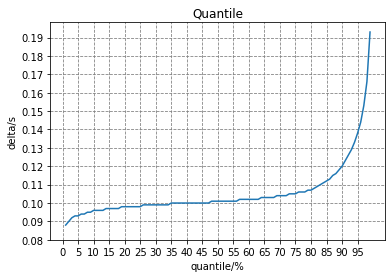

In [67]:
fig, axs = plt.subplots(1, 1)
plt.plot(range(1,100), np.percentile(delta_t, range(1,100)))
axs.set_axisbelow(True)
axs.xaxis.grid(color='gray', linestyle='dashed')
axs.yaxis.grid(color='gray', linestyle='dashed')
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0.08, 0.2, 0.01))
plt.title('Quantile')
plt.xlabel('quantile/%')
plt.ylabel('delta/s')

The values above indicates that the raw data is not in a same sample rate (the ideal sample rate is uniformly 10HZ), but most delta time fall into the interval from 0.09 to 0.14 so we just clip these value not in this interval and draw a histgram to see the distribution:

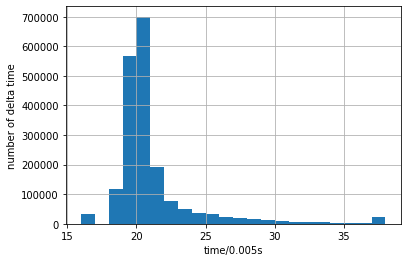

In [84]:
delta_t_copy = np.copy(delta_t)
delta_t_copy[delta_t<0.09] = 0.08
delta_t_copy[delta_t>0.19] = 0.19
delta_t_copy = (delta_t_copy/0.005).astype(int)
plt.hist(delta_t_copy.reshape(-1), bins=22)
plt.grid(True)
plt.xlabel('time/0.005s')
plt.ylabel('number of delta time')
del delta_t_copy

# traj
> to save time, just overview 1000 sampled sequence
- x,y 
- agent x y speed
- neighbor: num x,y speed

In [173]:
samples = np.random.choice(range(0, len(afl)), 1000)
# samples = range(len(afl))
n_nei = []
agent_movement = []
traj_length = []
distance = []
candidate_lane_num = []
x_max, y_max = -np.inf, -np.inf
x_min, y_min = np.inf, np.inf
for i in samples:
    seq = afl[i]
    agent_traj = seq.agent_traj
    assert len(agent_traj) == 50, 'agent traj is not full'

    movement = np.abs(agent_traj[1:] - agent_traj[:-1]).sum(axis=0)
    agent_movement.append(movement)

    if agent_traj[:, 0].max() > x_max:
        x_max = agent_traj[:, 0].max()
    if agent_traj[:, 0].min() < x_min:
        x_min = agent_traj[:, 0].min()
    if agent_traj[:, 1].max() > y_max:
        y_max = agent_traj[:, 1].max()
    if agent_traj[:, 1].min() < y_min:
        y_min = agent_traj[:, 1].min()
    
    num_track = seq.num_tracks
    n_nei.append(num_track-1)
    
    df = seq.seq_df
    traj_length += list(df.groupby(by='TRACK_ID')['X'].count())
    # compute distance
    base_ts = df.TIMESTAMP.unique()[19]
    base_agent_xy = agent_traj[19]
    neighbor_rows = df.loc[(df['TIMESTAMP'] == base_ts) & (df['OBJECT_TYPE'] != 'AGENT')]
    nei_xy = neighbor_rows[['X', 'Y']].values
    dist = nei_xy - base_agent_xy
    distance.append(dist)
    # lane num
    candidate_centerlines = avm.get_candidate_centerlines_for_traj(agent_traj[:20], seq.city, viz=False)
    candidate_lane_num.append(len(candidate_centerlines))
agent_movement = np.array(agent_movement)
n_nei = np.array(n_nei)
distance = np.concatenate(distance, axis=0)
candidate_lane_num = np.array(candidate_lane_num)

## Agent
Let's see the extent of X,Y coordinate:

In [152]:
print(f'x_max:{x_max}, x_min:{x_min}, y_max:{y_max}, y_min:{y_min}')
print(f'max X movement: {agent_movement[:,0].max()}')
print(f'min X movement: {agent_movement[:,0].min()}')
print(f'max Y movement: {agent_movement[:,1].max()}')
print(f'min Y movement: {agent_movement[:,1].min()}')

x_max:2272.6038642106923, x_min:121.11405856459172, y_max:1674.7130791167651, y_min:271.5397359040224
max X movement: 129.82802599582607
min X movement: 0.5697891570825959
max Y movement: 166.46808809860045
min Y movement: 0.5561633122526928


Text(367.48863636363626, 0.5, 'Y movement/m')

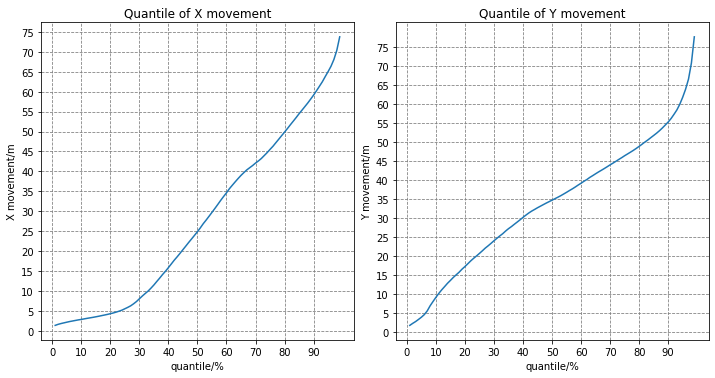

In [153]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.tight_layout()
axs[0].plot(range(1,100), np.percentile(agent_movement[:, 0], range(1,100)))
axs[0].set_axisbelow(True)
axs[0].xaxis.grid(color='gray', linestyle='dashed')
axs[0].yaxis.grid(color='gray', linestyle='dashed')
axs[0].set_xticks(np.arange(0, 100, 10))
axs[0].set_yticks(np.arange(0, 80, 5))
axs[0].set_title('Quantile of X movement')
axs[0].set_xlabel('quantile/%')
axs[0].set_ylabel('X movement/m')

axs[1].plot(range(1,100), np.percentile(agent_movement[:, 1], range(1,100)))
axs[1].set_axisbelow(True)
axs[1].xaxis.grid(color='gray', linestyle='dashed')
axs[1].yaxis.grid(color='gray', linestyle='dashed')
axs[1].set_xticks(np.arange(0, 100, 10))
axs[1].set_yticks(np.arange(0, 80, 5))
axs[1].set_title('Quantile of Y movement')
axs[1].set_xlabel('quantile/%')
axs[1].set_ylabel('Y movement/m')

From fig above, we can see basically the agent vehicles's movement (in a sequence) are **quite scattered**, and at the same time, movement along Y-direction is longer than that along X-direction.

Distribution of the length of traj

Text(0, 0.5, 'num of track')

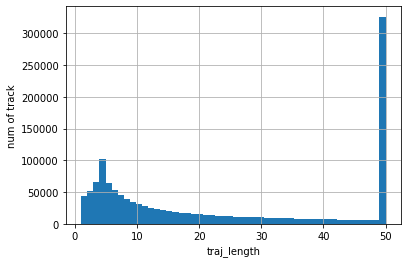

In [154]:
plt.hist(traj_length, bins=50)
plt.grid(True)
plt.xlabel('traj_length')
plt.ylabel('num of track')

## neighbor

In [158]:
print(f'max neighbor num: {n_nei.max()}, arg:{n_nei.argmax()}, min neighbor num: {n_nei.min()}, arg:{n_nei.argmin()}')

max neighbor num: 195, arg:5701, min neighbor num: 3, arg:112


In [161]:
afl.seq_list[112]

PosixPath('/data/zhaoyi/datasets/argo/forecasting/val/data/4009.csv')

Text(0, 0.5, 'num of agent')

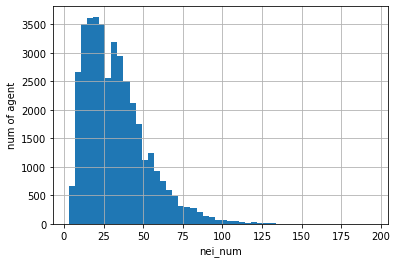

In [163]:
plt.hist(n_nei, bins=50)
plt.grid(True)
plt.title('Num of neighbors')
plt.xlabel('nei_num')
plt.ylabel('num of agent')

Distance from agent

Text(367.48863636363626, 0.5, 'num of neighbors')

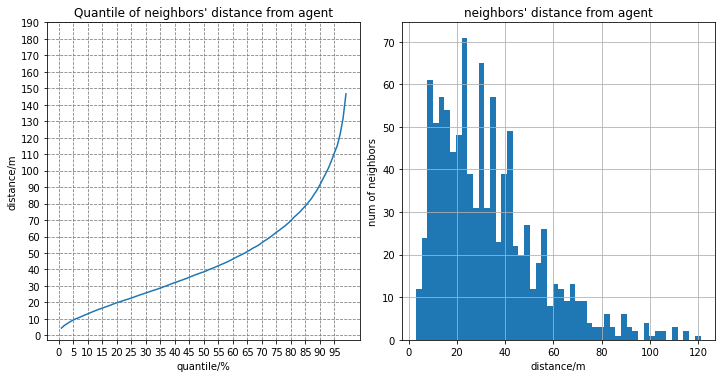

In [181]:
distance_norm = np.linalg.norm(distance, axis=1)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.tight_layout()
axs[0].plot(range(1,100), np.percentile(distance_norm, range(1,100)))
axs[0].set_axisbelow(True)
axs[0].xaxis.grid(color='gray', linestyle='dashed')
axs[0].yaxis.grid(color='gray', linestyle='dashed')
axs[0].set_xticks(np.arange(0, 100, 5))
axs[0].set_yticks(np.arange(0, 200, 10))
axs[0].set_title('Quantile of neighbors\' distance from agent')
axs[0].set_xlabel('quantile/%')
axs[0].set_ylabel('distance/m')

distance_norm = np.ceil(distance_norm)
axs[1].hist(n_nei, bins=50)
axs[1].grid(True)
axs[1].set_title('neighbors\' distance from agent')
axs[1].set_xlabel('distance/m')
axs[1].set_ylabel('num of neighbors')

# Lane

Text(0, 0.5, 'num of lanes')

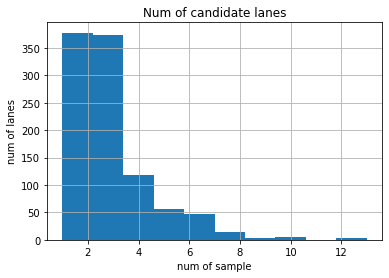

In [184]:
plt.hist(candidate_lane_num)
plt.grid(True)
plt.title('Num of candidate lanes')
plt.xlabel('num of sample')
plt.ylabel('num of lanes')